# Setup environment

In [1]:
%matplotlib inline

In [2]:
# In case of plotly not showing the charts run!
import plotly.io as pio
pio.renderers.default='notebook'

# Load Data

In [3]:
import pandas as pd

# Get Evaluation data
X_eval= pd.read_csv('data/X_eval_20200206.csv')
X_eval = X_eval.sample(frac=0.2, random_state = 2020)

T_eval= pd.read_csv('data/T_eval_20200206.csv',names=['time'])
T_eval = T_eval.sample(frac=0.2, random_state = 2020)
T_eval = T_eval['time']

E_eval= pd.read_csv('data/E_eval_20200206.csv',names=['event'])
E_eval = E_eval.sample(frac=0.2, random_state = 2020)
E_eval = E_eval['event']

# Load model

In [4]:
# load model
from pysurvival.utils import load_model
model = load_model('model/churn_model_20200303.zip')

Loading the model from model/churn_model_20200303.zip


# Calcula risk groups

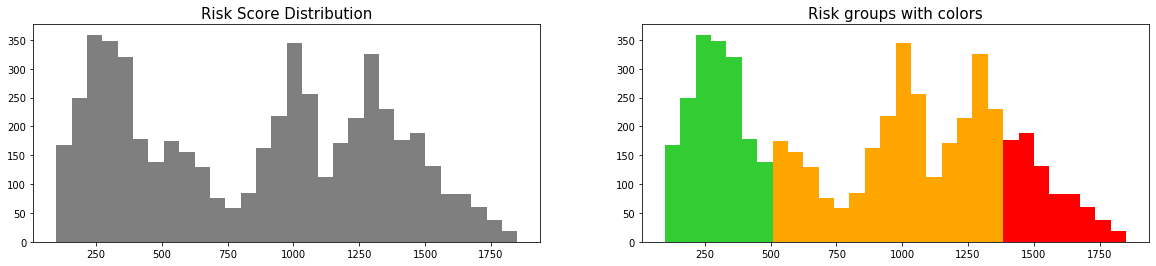

In [5]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=model, X=X_eval,
    use_log = False, num_bins=30, figure_size=(20, 4),
    low={'lower_bound':0, 'upper_bound':500, 'color':'limegreen'},
    medium={'lower_bound':500, 'upper_bound':1350,'color':'orange'},
    high={'lower_bound':1350, 'upper_bound':2000,  'color':'red'}
    )

# Test proposed solution

## RMSE model evaluation

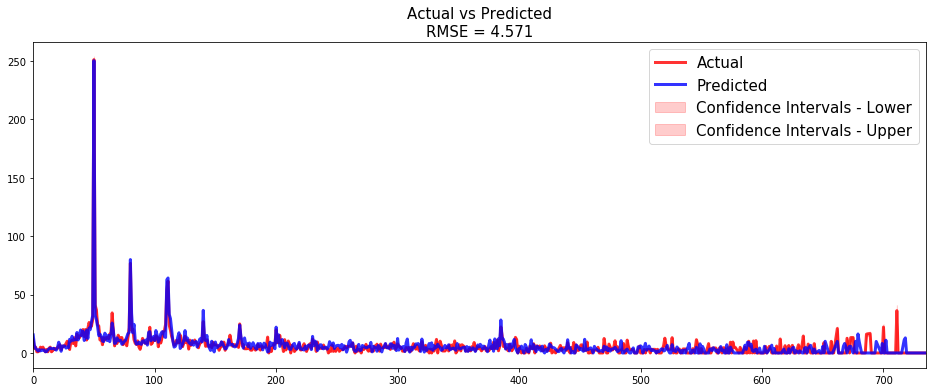

In [6]:
from pysurvival.utils.display import compare_to_actual

results = compare_to_actual(model, X_eval, T_eval, E_eval,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse'])

## Model performance on risk groups

In [7]:
import pandas as pd
import numpy as np

example = pd.DataFrame()

example['is_churn'] = np.where(E_eval == 1,1,0)
example['lifetime'] = T_eval.to_list()

example['true'] = np.where(example['lifetime'] <= 120,'high',
                          np.where(example['lifetime'] <= 365 ,'mid','low'))

example['pred'] = 'low'
example.iloc[risk_groups['high'][1],example.columns.get_loc('pred')] = 'high'
example.iloc[risk_groups['medium'][1],example.columns.get_loc('pred')] = 'mid'

example.head()

,is_churn,lifetime,true,pred
0,1,37,high,mid
1,1,65,high,mid
2,1,150,mid,mid
3,0,460,low,low
4,1,80,high,mid


In [8]:
from sklearn.metrics import precision_recall_fscore_support

prec,rec,f1,support = precision_recall_fscore_support(example['true'],example['pred'],pos_label=None,average='weighted')
print('Model - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(prec,rec))

result = precision_recall_fscore_support(example['true'],example['pred'],labels=['high','mid','low'])
print('High Risk - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(result[0][0],result[1][0]))
print('Mid Risk - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(result[0][1],result[1][1]))
print('Low Risk - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(result[0][2],result[1][2]))

Model - Precision: 0.55 - Recall: 0.48
High Risk - Precision: 0.74 - Recall: 0.35
Mid Risk - Precision: 0.39 - Recall: 0.52
Low Risk - Precision: 0.46 - Recall: 0.64


# Strategy example in numbers

In [9]:
print('Total clients: {0}'.format(len(X_eval)))
print('Clients in high risk group: {0}'.format(len(X_eval.iloc[risk_groups['high'][1]])))
print('Clients in mid risk group: {0}'.format(len(X_eval.iloc[risk_groups['medium'][1]])))
print('Clients in low risk group: {0}'.format(len(X_eval.iloc[risk_groups['low'][1]])))

r_high_v_high = len(X_eval.iloc[risk_groups['high'][1]].loc[X_eval['gmv_usd'] >= X_eval['gmv_usd'].mean()])
r_high_v_low = len(X_eval.iloc[risk_groups['high'][1]].loc[X_eval['gmv_usd'] < X_eval['gmv_usd'].mean()])
r_mid_v_high = len(X_eval.iloc[risk_groups['medium'][1]].loc[X_eval['gmv_usd'] >= X_eval['gmv_usd'].mean()])
r_mid_v_low = len(X_eval.iloc[risk_groups['medium'][1]].loc[X_eval['gmv_usd'] < X_eval['gmv_usd'].mean()])
r_low_v_high = len(X_eval.iloc[risk_groups['low'][1]].loc[X_eval['gmv_usd'] >= X_eval['gmv_usd'].mean()])
r_low_v_low = len(X_eval.iloc[risk_groups['low'][1]].loc[X_eval['gmv_usd'] < X_eval['gmv_usd'].mean()])

green_group = r_low_v_low + r_low_v_high + r_mid_v_low
yellow_group = r_mid_v_high + r_high_v_low
red_group = r_high_v_high

print('Clients in green group: {0} ({1}%)'.format(green_group,round((green_group /len(X_eval))*100,1)))
print('Clients in yellow group: {0} ({1}%)'.format(yellow_group,round((yellow_group /len(X_eval))*100,1)))
print('Clients in red group: {0} ({1}%)'.format(red_group,round((red_group /len(X_eval))*100,1)))

Total clients: 5248
Clients in high risk group: 1004
Clients in mid risk group: 2622
Clients in low risk group: 1622
Clients in green group: 4150 (79.1%)
Clients in yellow group: 1004 (19.1%)
Clients in red group: 94 (1.8%)
